In [91]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from PIL import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

## CÀRREGA DE DADES

In [92]:
train_path = "Mushrooms_V50_T50/train"
valid_path = "Mushrooms_V50_T50/valid"
test_path = "Mushrooms_V50_T50/test"

In [93]:
train_batches = ImageDataGenerator(rotation_range = 30, shear_range = 0.25, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True, width_shift_range=0.2, height_shift_range=0.2,preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
directory=train_path,target_size=(224,224),batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
directory=valid_path,target_size=(224,224),batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
directory=test_path,target_size=(224,224),batch_size=32,shuffle=False)

Found 8072 images belonging to 12 classes.
Found 600 images belonging to 12 classes.
Found 600 images belonging to 12 classes.


### CÀRREGA MODEL MOBILENET

In [94]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [95]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

#### FINETUNNING

In [96]:
x = mobile.layers[-6].output
x = keras.layers.Dense(1024)(x)
x = keras.layers.Dropout(0.5)(x)
output = Dense(units=12,activation="softmax")(x)

In [100]:
model = Model(inputs=mobile.input,outputs=output)

In [101]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [102]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

### ENTRENAMENT DEL MODEL

In [103]:
model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [104]:
modelcheckpoint = ModelCheckpoint("model_mobile.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1) 


history = model.fit(
    train_batches,
    steps_per_epoch = train_batches.samples / 32, 
    epochs = 100,
    validation_data = valid_batches,
    validation_steps = valid_batches.samples / 32,
    callbacks = [modelcheckpoint, earlystopping])

Epoch 1/100
252/252 [==============================] - 540s 2s/step - loss: 2.2565 - accuracy: 0.3239 - val_loss: 1.2314 - val_accuracy: 0.6083

Epoch 00001: val_accuracy improved from -inf to 0.60833, saving model to model_mobile.h5
Epoch 2/100
252/252 [==============================] - 523s 2s/step - loss: 1.2854 - accuracy: 0.5944 - val_loss: 1.0573 - val_accuracy: 0.6400

Epoch 00002: val_accuracy improved from 0.60833 to 0.64000, saving model to model_mobile.h5
Epoch 3/100
252/252 [==============================] - 568s 2s/step - loss: 1.0324 - accuracy: 0.6560 - val_loss: 1.0056 - val_accuracy: 0.6717

Epoch 00003: val_accuracy improved from 0.64000 to 0.67167, saving model to model_mobile.h5
Epoch 4/100
252/252 [==============================] - 539s 2s/step - loss: 0.9206 - accuracy: 0.7024 - val_loss: 0.9422 - val_accuracy: 0.6967

Epoch 00004: val_accuracy improved from 0.67167 to 0.69667, saving model to model_mobile.h5
Epoch 5/100
252/252 [==============================] - 


Epoch 00039: val_accuracy did not improve from 0.82500
Epoch 40/100
252/252 [==============================] - 482s 2s/step - loss: 0.1191 - accuracy: 0.9587 - val_loss: 1.1012 - val_accuracy: 0.7767

Epoch 00040: val_accuracy did not improve from 0.82500
Epoch 41/100
252/252 [==============================] - 483s 2s/step - loss: 0.1117 - accuracy: 0.9618 - val_loss: 1.3395 - val_accuracy: 0.7783

Epoch 00041: val_accuracy did not improve from 0.82500
Epoch 42/100
252/252 [==============================] - 483s 2s/step - loss: 0.1121 - accuracy: 0.9645 - val_loss: 1.4473 - val_accuracy: 0.7633

Epoch 00042: val_accuracy did not improve from 0.82500
Epoch 43/100
252/252 [==============================] - 486s 2s/step - loss: 0.1114 - accuracy: 0.9619 - val_loss: 1.3551 - val_accuracy: 0.7800

Epoch 00043: val_accuracy did not improve from 0.82500
Epoch 44/100
252/252 [==============================] - 501s 2s/step - loss: 0.1108 - accuracy: 0.9624 - val_loss: 1.1314 - val_accuracy: 0.

### Carreguem el model guardat

In [105]:
model_mobile=tf.keras.models.load_model('model_mobile.h5')

Altres models creats:

In [38]:
#model_mobile_1=tf.keras.models.load_model('model_mobile_1') #batch_size=10 
#model_mobile_2=tf.keras.models.load_model('model_mobile_2') #batch_size=32
#model_mobile_3=tf.keras.models.load_model('model_mobile_3') #batch_size=32


# Model Evaluate

In [106]:
test_loss, test_acc = model_mobile.evaluate(test_batches,verbose=1)

19/19 [==============================] - 19s 956ms/step - loss: 0.8928 - accuracy: 0.8150


# Model predictions / Confusion Matrix

In [107]:
test_labels = test_batches.classes

In [108]:
predictions = model_mobile.predict(x=test_batches,verbose=0)

In [109]:
cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

In [110]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


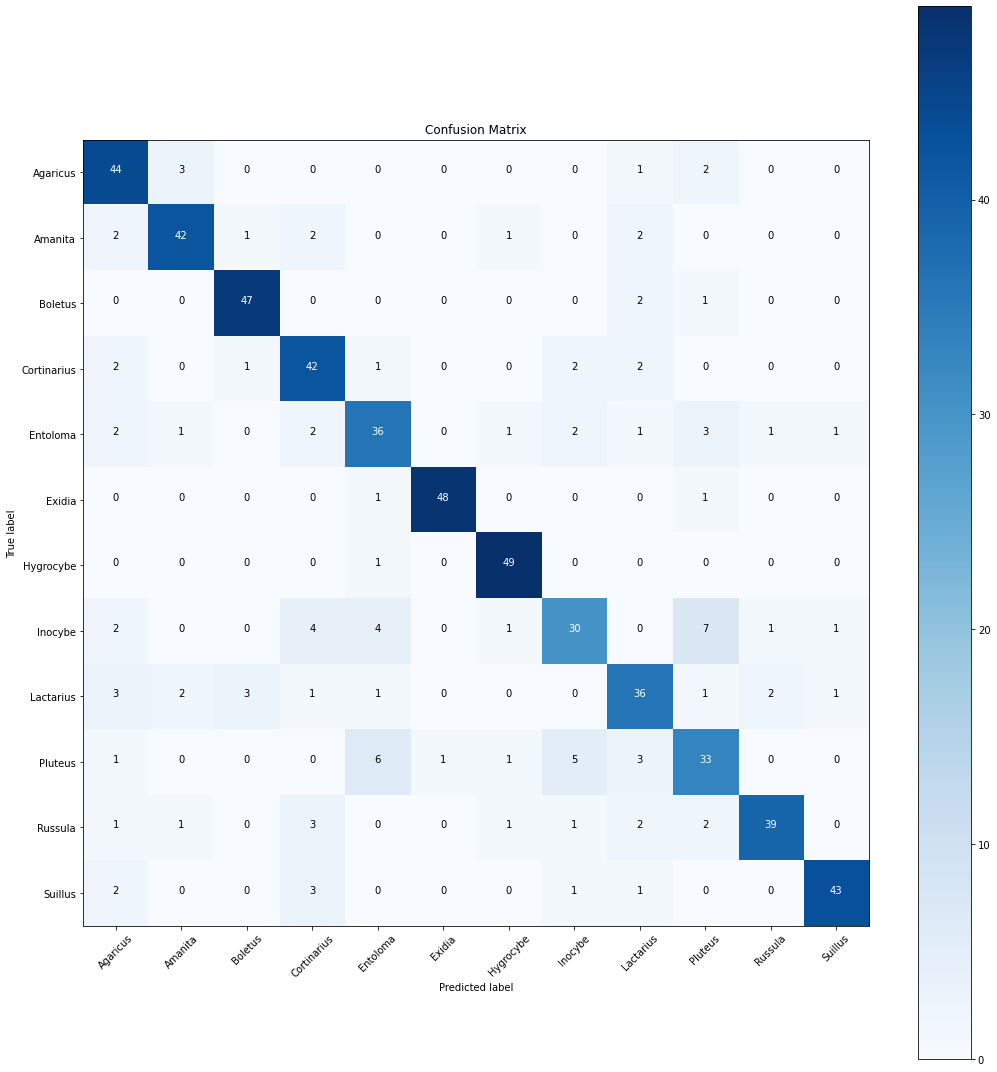

In [111]:
cm_plot_labels=['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")

# EXEMPLE IMAGE CLASSIFICATION

In [112]:
def prepare_image(file):
    img_path = "Mushrooms_V50_T50/test/"
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array,axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

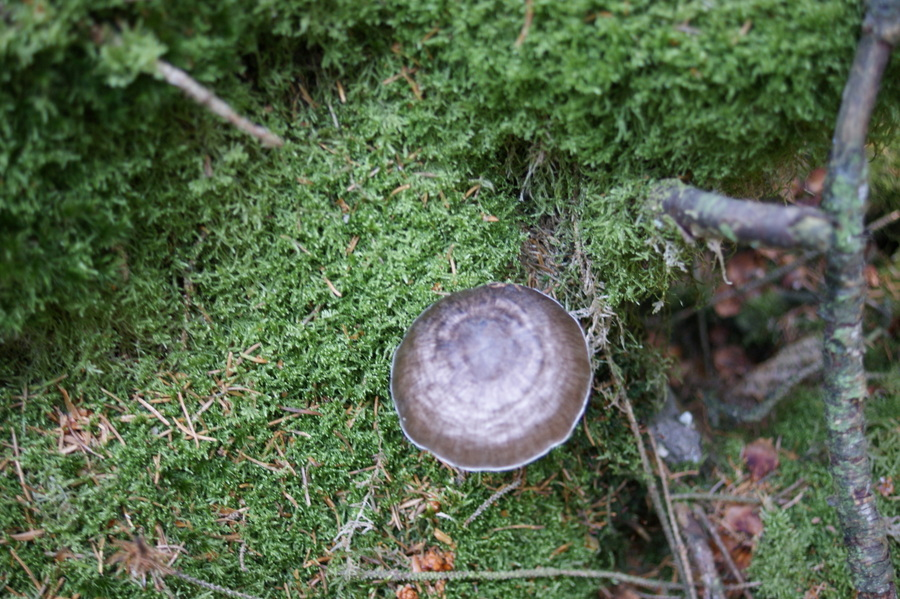

In [1]:
from IPython.display import Image 
Image(filename="Mushrooms_V50_T50/test/Pluteus/131.jpg",width=300,height=200)

In [114]:
preprocessed_image=prepare_image("Pluteus/131.jpg")
predictions = model_mobile.predict(preprocessed_image)
numbers_sort = sorted(enumerate(predictions[0]), key=lambda x: x[1],  reverse=True)
for i in range(3):
    print("Prob: {1} -- ".format(*numbers_sort[i]),"specie: {0}".format(*list(test_batches.class_indices.items())[numbers_sort[i][0]]))


Prob: 0.9999048709869385 --  specie: Pluteus
Prob: 9.308953303843737e-05 --  specie: Boletus
Prob: 1.2250048939677072e-06 --  specie: Lactarius


# APP ANDROID

Convertir a model .tflite

In [115]:
converter=tf.lite.TFLiteConverter.from_keras_model(model_mobile)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\polco\AppData\Local\Temp\tmpmnc139ig\assets


In [116]:
open("best_model_mobile_2.tflite", "wb").write(tflite_model)

17048184

Guardem .txt amb els labels

In [25]:
labels = '\n'.join(sorted(train_batches.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)